In [1]:
!poetry add $(cat requirements.txt)

zsh:1: command not found: poetry


In [2]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import certifi
import time
from tqdm import tqdm
from joblib import Memory
from binance.client import Client
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from typing import List, Dict, Any
from datetime import timedelta
from dataclasses import dataclass
import glob
import os

from enum import Enum




## COLLECT DATA

### collect market data using binance api


In [3]:
client = Client()
exchange_info = client.get_exchange_info()

print(f"market info: {len(exchange_info['symbols'])}")


market info: 2878


### fetch curent market data for all trading pairs which would later be filtered

In [4]:
tickers = client.get_ticker()
tickers_df = pd.DataFrame(tickers).set_index('symbol')
tickers_df['quoteVolume'] = pd.to_numeric(tickers_df['quoteVolume'])

print(tickers_df.head(5))

         priceChange priceChangePercent weightedAvgPrice prevClosePrice  \
symbol                                                                    
ETHBTC   -0.00006000             -0.172       0.03492651     0.03499000   
LTCBTC    0.00000000              0.000       0.00106778     0.00106400   
BNBBTC    0.00014300              1.994       0.00727287     0.00717200   
NEOBTC   -0.00000120             -0.783       0.00015183     0.00015330   
QTUMETH  -0.00001600             -1.702       0.00091812     0.00094900   

          lastPrice     lastQty    bidPrice         bidQty    askPrice  \
symbol                                                                   
ETHBTC   0.03492000  1.01530000  0.03492000  1342.71820000  0.03493000   
LTCBTC   0.00106400  7.90300000  0.00106300   269.16600000  0.00106400   
BNBBTC   0.00731500  0.15000000  0.00731300     6.06100000  0.00731500   
NEOBTC   0.00015210  1.49000000  0.00015190    59.64000000  0.00015220   
QTUMETH  0.00092400  2.3000000

### setup cache and data directories for data collected

In [5]:
cache_dir = "./.cache"
data_dir = "./data/historical"
os.makedirs(cache_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

### setup cache and make requests in batches 
- to avoid rate limiting
- to speed up the process
- to avoid redundant requests


In [6]:
memory = Memory(cache_dir)

BATCH_SIZE = 30
SLEEP_TIME = 1


### filter market data
why these filters?
- MIN_VOLUME: to avoid data that is too low (50,000 USDT)
- MIN_MARKET_CAP: to avoid data that is too low (1,000,000 USDT)
- MAX_MARKET_CAP: to avoid data that is too high (100,000,000 USDT) as requested in the assigment
- KLINE_INTERVAL: to avoid data that is too low (15m)
- DAILY_BARS: to avoid data that is too low (96 bars)


In [7]:
class MarketFilters(Enum):
    MIN_MARKET_CAP: float = 1_000_000.00  # 1M USDT min
    MAX_MARKET_CAP: float = 100_000_000.00  # 100M USDT max
    MIN_VOLUME: float = 50_000.00  # Minimum daily volume
    KLINE_INTERVAL: str = "15m"  # For short-term analysis
    DAILY_BARS: int = 96  # 96 bars per day

### filter market data for USDT pairs and volume

### collect eligible symbols in batches
for each potential symbol:
- filter market cap
- collect data

In [8]:
url = "https://www.binance.com/bapi/apex/v1/friendly/apex/marketing/complianceSymbolList"

try:
    # get market caps
    response = requests.get(
                url, headers={"Accept-Encoding": "gzip"}, verify=certifi.where()
            )
    data = response.json()

    volumes = {  t["symbol"]: float(t["quoteVolume"]) for t in client.get_ticker() if t["symbol"].endswith("USDT") }

    # find valid coins
    small_coins = []
    for token in data.get("data", []):
        symbol = token.get("symbol", "")
        mcap = token.get("marketCap")
        vol = volumes.get(symbol, 0)

            # check market cap and volume criteria
        if (
            symbol.endswith("USDT")
                and mcap is not None
                and MarketFilters.MIN_MARKET_CAP.value  # Access the value
                <= float(mcap)
                <= MarketFilters.MAX_MARKET_CAP.value  # Access the value
                and vol >= MarketFilters.MIN_VOLUME.value  # Access the value
            ):
            small_coins.append(symbol)

        print(f"symbol: {symbol} mcap: {mcap} vol: {vol}")

    print(f"Found {len(small_coins)} small-cap coins")

except Exception as e:
            print(f"Error finding small caps: {str(e)}")

symbol: 1000CATUSDT mcap: 183499452.9304711 vol: 15162672.781917
symbol: 1000SATSUSDT mcap: 283122547.80667126 vol: 60205243.6135093
symbol: 1INCHUSDT mcap: 522121795.7945526 vol: 7236167.79341
symbol: 1MBABYDOGEUSDT mcap: 437649903.52794117 vol: 19723540.6462058
symbol: AAVEUSDT mcap: 4362561408.913493 vol: 76724523.5348
symbol: ACAUSDT mcap: 100463310.88666373 vol: 5705359.675414
symbol: ACEUSDT mcap: 82036282.97130883 vol: 2983323.826
symbol: ACHUSDT mcap: 195756255.4527572 vol: 4547019.39248
symbol: ACMUSDT mcap: 9601232.77580239 vol: 660030.6878
symbol: ACTUSDT mcap: 277417951.4848468 vol: 137721118.20029
symbol: ACXUSDT mcap: 153439398.01198778 vol: 10117379.61267
symbol: ADAUSDT mcap: 32569596196.176605 vol: 357288437.35282
symbol: ADXUSDT mcap: 28544654.16708576 vol: 3172299.3548
symbol: AERGOUSDT mcap: 60114321.79452705 vol: 2906380.95
symbol: AEURUSDT mcap: 56651026.55243478 vol: 283162.14075
symbol: AEVOUSDT mcap: 297324663.3462396 vol: 8507288.823319
symbol: AGLDUSDT mcap: 

### collect historical data on eligible symbols


#### time frame choice:
- the proposed 10m time frame for granularity could not be fetched since Binance API doesn't support it.
- the closest granularity that can be fetched is 15m
- data collected should be sufficient for the training of the model


In [9]:
def cached_get_klines(symbol, interval="15m"):
        """cache historical data requests"""
        @memory.cache
        def _get_klines(symbol=symbol, interval=interval):
            """get klines"""
            end_time = int(pd.Timestamp.now().timestamp() * 1000)
            start_time = int((pd.Timestamp.now() - pd.Timedelta(days=97)).timestamp() * 1000)
            all_klines = []
            current_start = start_time
            
            while current_start < end_time:
                klines = client.get_klines(
                    symbol=symbol,
                    interval=interval,
                    limit=1000,
                    startTime=current_start,
                    endTime=end_time
                )
                
                if not klines:
                    break
                    
                all_klines.extend(klines)
                
                current_start = klines[-1][0] + 1
                
            
            return all_klines

        return _get_klines

In [10]:
print("\nCollecting historical data...")
for i in range(0, len(small_coins), BATCH_SIZE):
    batch = small_coins[i : i + BATCH_SIZE]

    for symbol in tqdm(batch, desc=f"Batch {i//BATCH_SIZE + 1}"):
        try:
            # Get the cached function and call it to get the actual klines
            klines_func = cached_get_klines(
                    symbol=symbol, 
                    interval=MarketFilters.KLINE_INTERVAL.value
                )
            klines = klines_func()  # Call the function to get the actual data

            if len(klines) < MarketFilters.DAILY_BARS.value * 97:  # (training period + 1 week) * daily bars
                continue

            # Extract only OHLCV data from klines
            df = pd.DataFrame([
                [
                    k[0],  # timestamp
                    float(k[1]),  # open
                    float(k[2]),  # high
                    float(k[3]),  # low
                    float(k[4]),  # close
                    float(k[5])   # volume
                ] 
                for k in klines
            ], columns=["timestamp", "open", "high", "low", "close", "volume"])

            df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
            df.set_index("timestamp", inplace=True)

            df.to_csv(f"data/historical/historical_{symbol}.csv")

        except Exception as e:
            print(f"Error collecting {symbol}: {e}")

        if i + BATCH_SIZE < len(small_coins):
            time.sleep(SLEEP_TIME)  # Avoid rate limits

Batch 4: 100%|██████████| 28/28 [00:10<00:00,  2.61it/s]


## FEATURE ENGINEERING

### feature params
- volatility_window: 10
- volume_ma_window: 7
- rsi_window: 12

In [5]:
from sklearn.model_selection import TimeSeriesSplit
import warnings

class FeatureEngineer:
    def __init__(self):
        self.feature_columns = [
            'returns',
            'rsi',
            'bb_position',
            'volatility',
            'momentum'
        ]

    def calculate_rsi(self, data: pd.Series, period: int = 14) -> pd.Series:
        """Calculate the Relative Strength Index (RSI)."""
        delta = data.diff()
        gain = delta.where(delta > 0, 0).rolling(window=period).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
        rs = gain / (loss + 1e-8)
        return 100 - (100 / (1 + rs))

    def calculate_features(self, data: pd.DataFrame) -> pd.DataFrame:
        """Calculate features optimized for short-term HMM on small caps"""
        features = pd.DataFrame(index=data.index)
        
        # Core features for regime detection
        features['returns'] = np.log(data['close']).diff()
        features['volatility'] = (data['high'] - data['low']) / data['close']
        features['volatility'] = np.log1p(features['volatility'])
        
        # Oscillators with shorter periods for small caps
        features['rsi'] = self.calculate_rsi(data['close'], period=10)  # shorter period
        
        # Modified BB position with tighter bands for small caps
        bb_period = 15  # shorter period
        bb_std = 1.8    # tighter bands
        middle_band = data['close'].rolling(bb_period).mean()
        std_dev = data['close'].rolling(bb_period).std()
        upper_bb = middle_band + (bb_std * std_dev)
        lower_bb = middle_band - (bb_std * std_dev)
        features['bb_position'] = (data['close'] - lower_bb) / (upper_bb - lower_bb)
        
        # Short-term momentum (modified)
        features['momentum'] = (data['close'] / data['close'].shift(5) - 1).ewm(span=3).mean()
        
        # drop NaN values
        features = features.dropna()
        
        # Normalize features
        for col in features.columns:
            if col in ['rsi', 'bb_position']:  # Keep these in original scale
                continue
            elif col == 'volatility':
                features[col] = np.abs(features[col])
            elif col == 'returns':
                features[col] = features[col].clip(-0.15, 0.15)  # Wider clips for small caps
            else:
                max_abs_val = np.abs(features[col]).max()
                if max_abs_val > 0:
                    features[col] = features[col] / max_abs_val
        
        return features
    
    def find_optimal_states(self, features: pd.DataFrame, min_states: int = 2, max_states: int = 5, 
                      n_splits: int = 5) -> tuple[int, float]:
        """Find optimal number of HMM states using cross-validation"""
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        best_score = float('-inf')
        best_n_states = min_states
        scores_by_state = {}
        
        # Suppress convergence warnings
            
        for n_states in range(min_states, max_states + 1):
            cv_scores = []
                
            for train_idx, val_idx in tscv.split(features):
                    train_features = features.iloc[train_idx]
                    val_features = features.iloc[val_idx]
                    
                    model = hmm.GaussianHMM(
                        n_components=n_states,
                        covariance_type="diag",
                        n_iter=150,
                        random_state=42,
                        tol=1e-3  # Increased tolerance for convergence
                    )
                    
                    try:
                        model.fit(train_features)
                        score = model.score(val_features)
                        cv_scores.append(score)
                    except Exception as e:
                        print(f"Warning: Failed to fit model with {n_states} states: {str(e)}")
                        continue
                
                if cv_scores:
                    mean_score = np.mean(cv_scores)
                    scores_by_state[n_states] = mean_score
                    
                    if mean_score > best_score:
                        best_score = mean_score
                        best_n_states = n_states
                        
                    print(f"States: {n_states}, Average Score: {mean_score:.2f}")
        
        return best_n_states, best_score
    
    def prepare_train_test(self, data: pd.DataFrame) -> tuple:
        """Prepare training and testing datasets with fixed 3-month training period"""
        features = self.calculate_features(data)
        
        train_size = 90 * 24 * 4  # 90 days * 24 hours * 4 (15-min intervals)

        
        if len(features) < train_size:
            raise ValueError(f"Not enough data. Need at least {train_size} rows, but got {len(features)}")
        
        train_data = features[:train_size]
        test_data = features[train_size:]
        
        print(f"\nData Split Info:")
        print(f"Training period: {train_data.index[0]} to {train_data.index[-1]}")
        print(f"Testing period: {test_data.index[0]} to {test_data.index[-1]}")
        print(f"Training samples: {len(train_data)}")
        print(f"Testing samples: {len(test_data)}")
        
        return train_data, test_data
    
    

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 98)

### calculate features

In [12]:
# RSI and ATR calculations


# def calculate_atr(self, high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
#     """Calculate the Average True Range (ATR)."""
#     tr = pd.concat([
#         high - low,
#         abs(high - close.shift()),
#         abs(low - close.shift())
#     ], axis=1).max(axis=1)
#     return tr.rolling(window=period).mean()


# FeatureEngineer.calculate_atr = calculate_atr






In [13]:

# # Volume and Momentum indicators
# def calculate_obv(self, close: pd.Series, volume: pd.Series) -> pd.Series:
#     """Calculate the On-Balance Volume (OBV)."""
#     obv = (np.sign(close.diff()) * volume).fillna(0).cumsum()
#     return obv

# def calculate_macd(self, data: pd.Series, short_period: int = 12, 
#                   long_period: int = 26, signal_period: int = 9) -> pd.Series:
#     """Calculate the Moving Average Convergence Divergence (MACD)."""
#     short_ema = data.ewm(span=short_period, adjust=False).mean()
#     long_ema = data.ewm(span=long_period, adjust=False).mean()
#     macd = short_ema - long_ema
#     signal = macd.ewm(span=signal_period, adjust=False).mean()
#     return macd - signal

# FeatureEngineer.calculate_obv = calculate_obv
# FeatureEngineer.calculate_macd = calculate_macd

In [14]:
# Main feature calculation method


# FeatureEngineer.calculate_features = calculate_features

In [15]:
# Train-test split functionality


# FeatureEngineer.prepare_train_test = prepare_train_test

In [16]:
## TRAINING DATA

# let's set up our training window (last 3 months)
def prepare_training_data(df: pd.DataFrame, training_days: int = 90) -> pd.DataFrame:
    """prepare training data with specified window"""
    end_date = df.index[-1]
    start_date = end_date - timedelta(days=training_days)
    return df[start_date:end_date]

In [17]:
# Create an instance and test
engineer = FeatureEngineer()
print("Available features:", engineer.feature_columns)

Available features: ['returns', 'rsi', 'bb_position', 'volatility', 'momentum']


### visualize feature selection
sample analysis on the first symbol

Model is not converging.  Current: 8107.809456826758 is not greater than 8107.811258161409. Delta is -0.0018013346507359529



Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 8389.707258922368 is not greater than 8389.751054317456. Delta is -0.04379539508772723
Model is not converging.  Current: 24326.395698700882 is not greater than 24326.490681607844. Delta is -0.09498290696137701
Model is not converging.  Current: 32557.947575938386 is not greater than 32558.003422016314. Delta is -0.05584607792843599
Model is not converging.  Current: 18086.69535210113 is not greater than 18086.84474921074. Delta is -0.14939710960970842
Model is not converging.  Current: 25302.295548457045 is not greater than 25302.404959877123. Delta is -0.1094114200786862


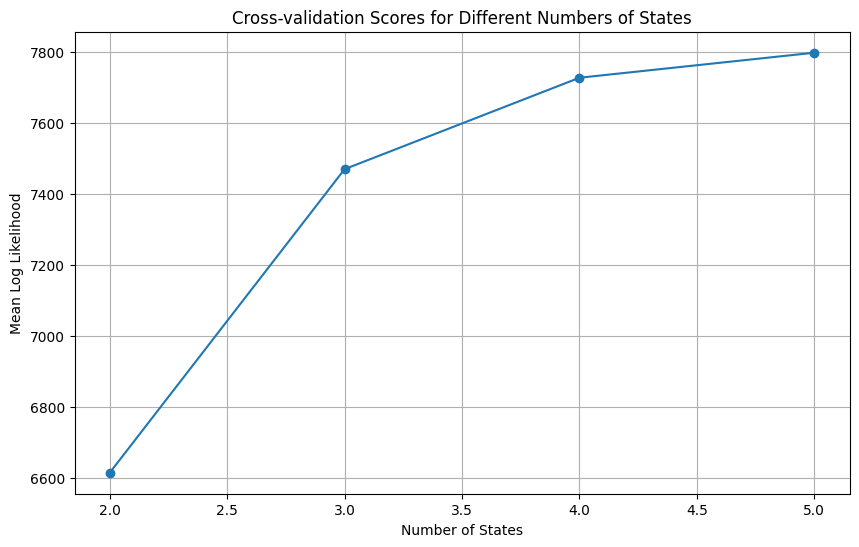

Model is not converging.  Current: 12323.870061321026 is not greater than 12323.870071340745. Delta is -1.0019719411502592e-05


CATIUSDT - Optimal states: 5 (CV Score: 7797.93)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 12542.92441346651 is not greater than 12542.927039247088. Delta is -0.0026257805784553057
Model is not converging.  Current: 12458.152032434968 is not greater than 12507.179117736829. Delta is -49.02708530186101
Model is not converging.  Current: 50040.64633769929 is not greater than 50040.67154453603. Delta is -0.02520683674083557
Model is not converging.  Current: 12607.569765240169 is not greater than 12647.102331072205. Delta is -39.5325658320362
Model is not converging.  Current: 50411.742716319524 is not greater than 50411.98437052194. Delta is -0.24165420241479296


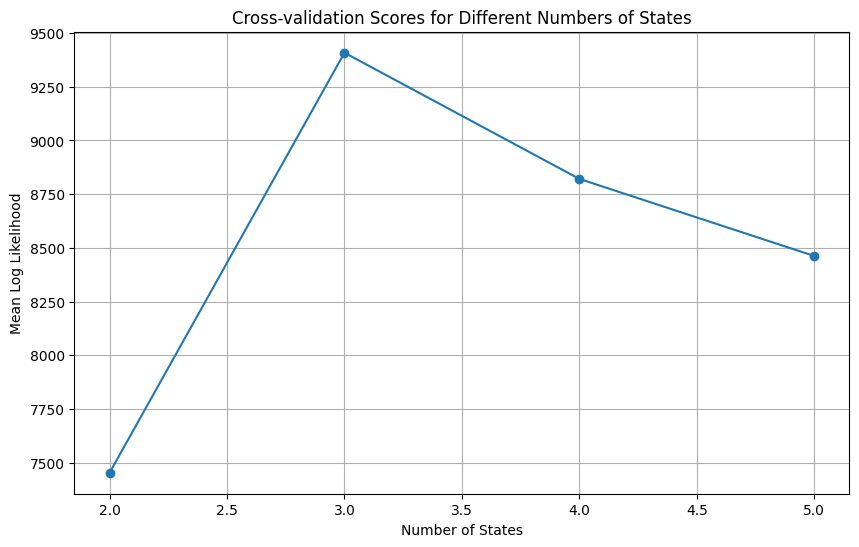

FIROUSDT - Optimal states: 3 (CV Score: 9407.95)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 26893.010394606914 is not greater than 26893.74214921451. Delta is -0.7317546075973951
Model is not converging.  Current: 41734.0177469065 is not greater than 41734.91207153646. Delta is -0.8943246299604652
Model is not converging.  Current: 18979.262522369987 is not greater than 18979.337318407306. Delta is -0.0747960373191745
Model is not converging.  Current: 36740.7869673012 is not greater than 36741.00053218225. Delta is -0.21356488104356686
Model is not converging.  Current: 9811.049002791824 is not greater than 9811.050724742468. Delta is -0.0017219506444234867
Model is not converging.  Current: 28771.48677586339 is not greater than 28771.810670374012. Delta is -0.3238945106204483
Model is not converging.  Current: 9871.781855684674 is not greater than 9871.814648942942. Delta is -0.032793258267702186


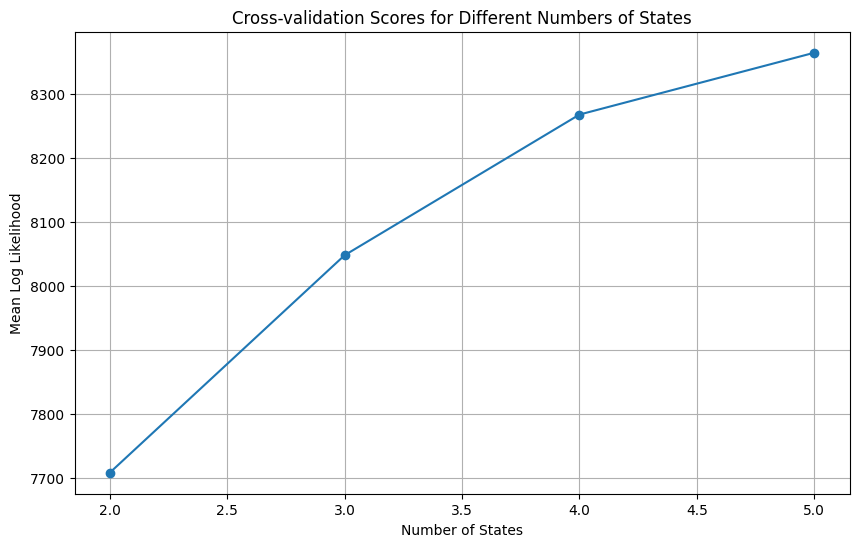

GTCUSDT - Optimal states: 5 (CV Score: 8365.19)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 8587.001708693728 is not greater than 8587.099702670766. Delta is -0.09799397703864088
Model is not converging.  Current: 47920.98222640483 is not greater than 47921.3870714354. Delta is -0.4048450305708684
Model is not converging.  Current: 8646.605221880194 is not greater than 8721.785245019068. Delta is -75.18002313887337
Model is not converging.  Current: 18771.597847916422 is not greater than 18771.64746392051. Delta is -0.04961600408933009
Model is not converging.  Current: 19387.541776763257 is not greater than 19387.568900699185. Delta is -0.027123935928102583
Model is not converging.  Current: 40880.915627322756 is not greater than 40881.03913346298. Delta is -0.12350614022579975


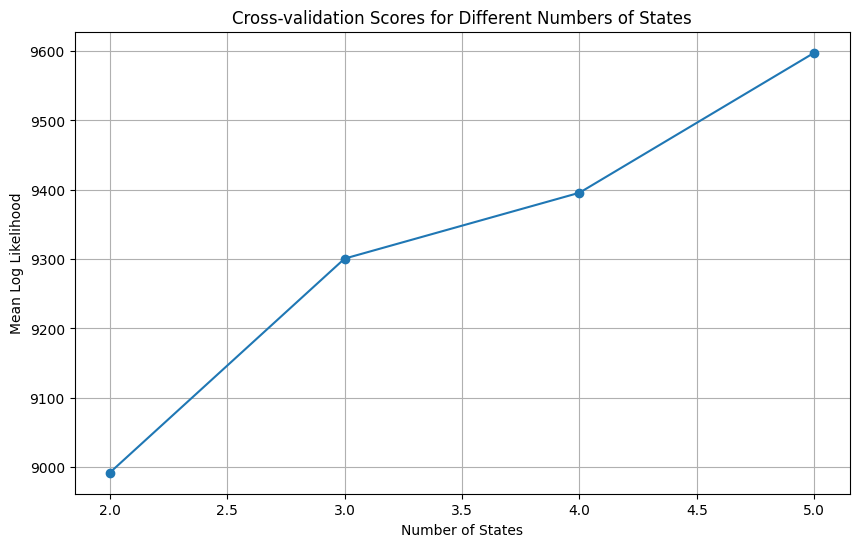

Model is not converging.  Current: 8460.312570095964 is not greater than 8460.642051855313. Delta is -0.3294817593487096


CITYUSDT - Optimal states: 5 (CV Score: 9597.75)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 28845.85960399655 is not greater than 28846.73443275391. Delta is -0.8748287573616835
Model is not converging.  Current: 18577.695132484685 is not greater than 18643.482926081404. Delta is -65.78779359671898
Model is not converging.  Current: 48851.65239191245 is not greater than 48851.67371033389. Delta is -0.02131842143717222
Model is not converging.  Current: 50750.839942517676 is not greater than 50750.84878627197. Delta is -0.008843754294503015


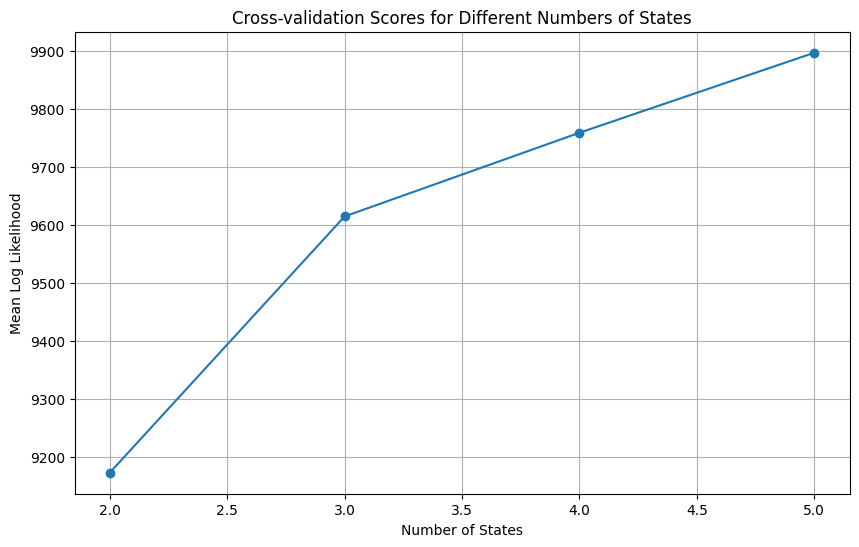

BARUSDT - Optimal states: 5 (CV Score: 9896.19)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 20909.84465341463 is not greater than 20909.84672256352. Delta is -0.002069148889859207
Model is not converging.  Current: 30219.051514048897 is not greater than 30219.272865883762. Delta is -0.22135183486534515
Model is not converging.  Current: 39336.58943517544 is not greater than 39337.24335604472. Delta is -0.6539208692774992
Model is not converging.  Current: 9965.558902262774 is not greater than 9965.569470456981. Delta is -0.01056819420773536
Model is not converging.  Current: 50459.136737584755 is not greater than 50459.14076584131. Delta is -0.004028256553283427
Model is not converging.  Current: 31709.88768936477 is not greater than 31709.998683487487. Delta is -0.11099412271869369
Model is not converging.  Current: 51260.02007680067 is not greater than 51260.1579356991. Delta is -0.13785889842984034


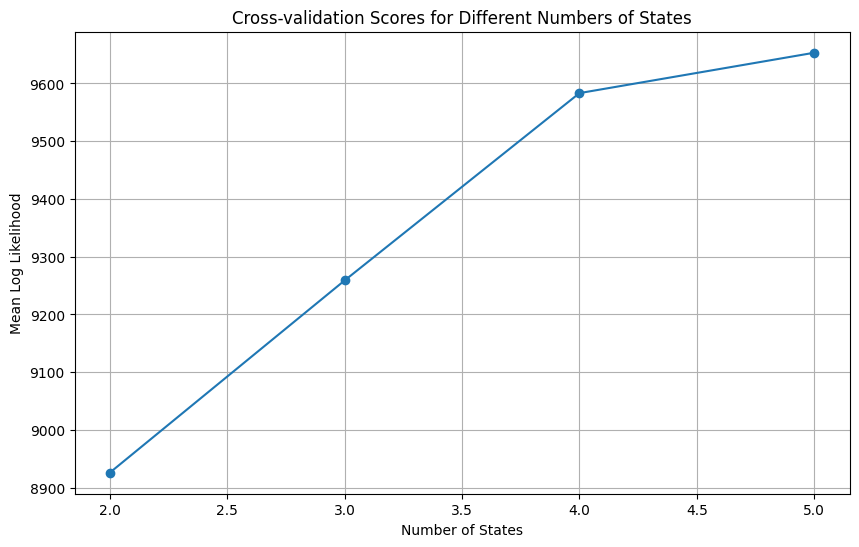

ALCXUSDT - Optimal states: 5 (CV Score: 9653.17)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 18419.469595251052 is not greater than 18419.71776965008. Delta is -0.24817439902835758
Model is not converging.  Current: 9166.28805664242 is not greater than 9166.461854573488. Delta is -0.1737979310692026
Model is not converging.  Current: 18897.25855595622 is not greater than 18897.268979416. Delta is -0.010423459778394317
Model is not converging.  Current: 8739.287543861334 is not greater than 8742.931048568562. Delta is -3.643504707228203
Model is not converging.  Current: 19073.245124604207 is not greater than 19073.24616274649. Delta is -0.0010381422835052945
Model is not converging.  Current: 44199.14504051467 is not greater than 44199.270143156406. Delta is -0.12510264173761243


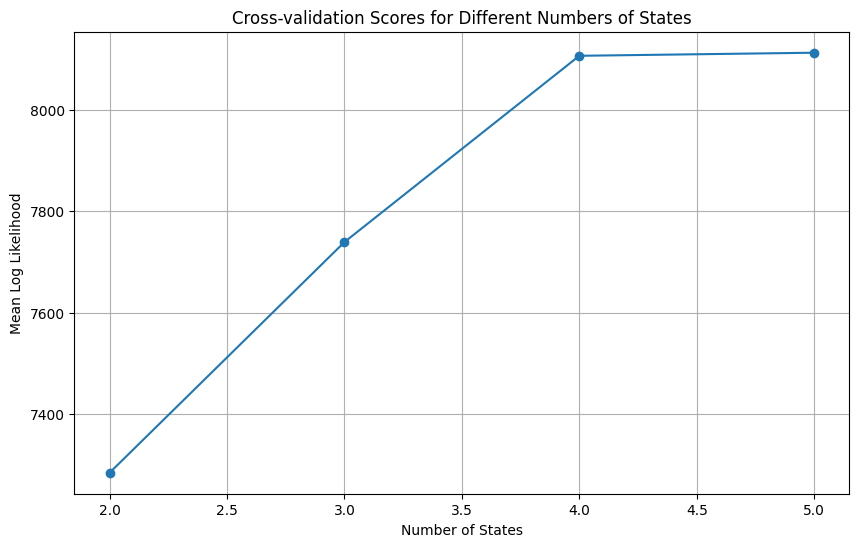

ACEUSDT - Optimal states: 5 (CV Score: 8112.28)

Data Split Info:
Training period: 2024-10-03 15:15:00 to 2025-01-01 15:00:00
Testing period: 2025-01-01 15:15:00 to 2025-01-08 11:30:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 9945.629254134887 is not greater than 9945.695105036031. Delta is -0.0658509011445858
Model is not converging.  Current: 19403.353186741097 is not greater than 19405.2976808441. Delta is -1.9444941030051268
Model is not converging.  Current: 29452.32911036281 is not greater than 29452.464183798653. Delta is -0.13507343584205955
Model is not converging.  Current: 30089.454448011762 is not greater than 30089.455499781783. Delta is -0.001051770021149423
Model is not converging.  Current: 38681.620927354656 is not greater than 38681.65616262876. Delta is -0.03523527410288807
Model is not converging.  Current: 10014.547620463249 is not greater than 10014.553937275754. Delta is -0.006316812505247071
Model is not converging.  Current: 19925.62686463246 is not greater than 19927.053570465225. Delta is -1.426705832764128


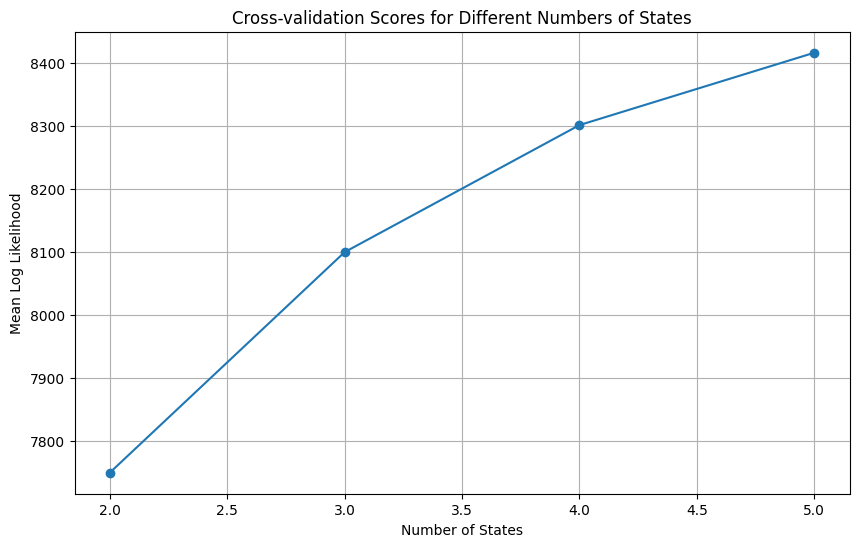

PDAUSDT - Optimal states: 5 (CV Score: 8415.75)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 9794.06395881103 is not greater than 9794.065206614941. Delta is -0.00124780391161039
Model is not converging.  Current: 37501.50081807688 is not greater than 37501.551354111776. Delta is -0.050536034897959325
Model is not converging.  Current: 45861.922116734444 is not greater than 45861.93974011611. Delta is -0.01762338166736299
Model is not converging.  Current: 20463.78099280944 is not greater than 20463.950183994144. Delta is -0.16919118470468675
Model is not converging.  Current: 38183.53529686586 is not greater than 38183.5390107108. Delta is -0.003713844940648414
Model is not converging.  Current: 46278.7063338215 is not greater than 46278.907048900415. Delta is -0.20071507891407236


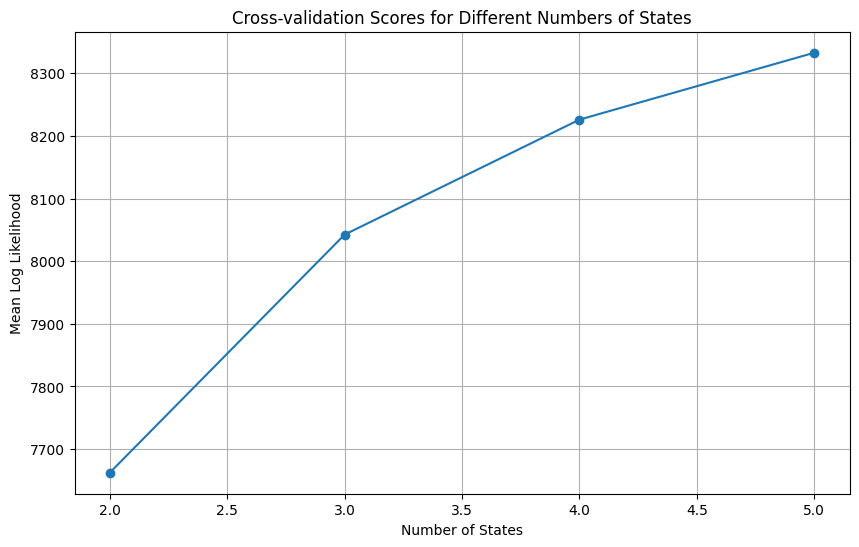

BADGERUSDT - Optimal states: 5 (CV Score: 8332.95)

Data Split Info:
Training period: 2024-10-03 15:15:00 to 2025-01-01 15:00:00
Testing period: 2025-01-01 15:15:00 to 2025-01-08 11:30:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 9705.491204810118 is not greater than 9705.540620325117. Delta is -0.04941551499905472
Model is not converging.  Current: 43014.70506294393 is not greater than 43014.7114956063. Delta is -0.006432662368752062
Model is not converging.  Current: 9207.15791980189 is not greater than 9242.691413628392. Delta is -35.53349382650231


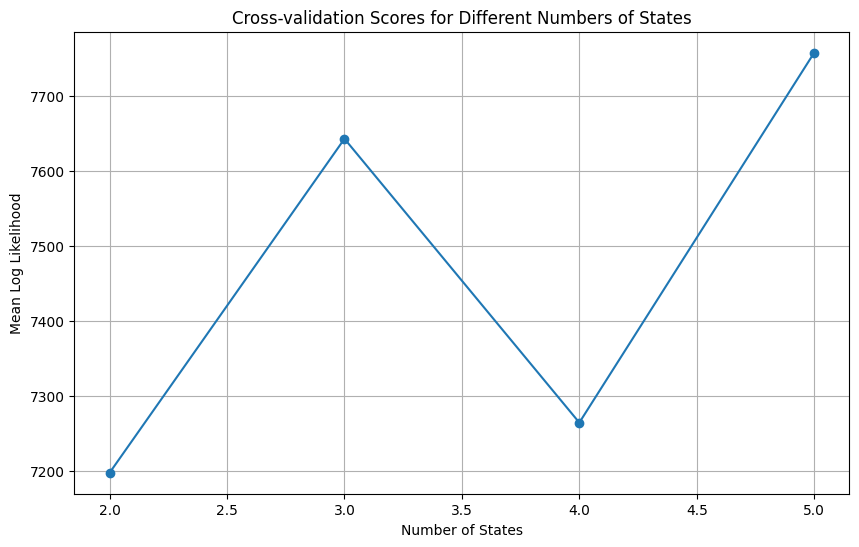

MBOXUSDT - Optimal states: 5 (CV Score: 7757.79)

Data Split Info:
Training period: 2024-10-03 15:15:00 to 2025-01-01 15:00:00
Testing period: 2025-01-01 15:15:00 to 2025-01-08 11:30:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 7671.269814553318 is not greater than 7671.386989626177. Delta is -0.11717507285902684
Model is not converging.  Current: 30584.28951511644 is not greater than 30584.597944034318. Delta is -0.3084289178768813
Model is not converging.  Current: 31940.831471637735 is not greater than 31940.860203064265. Delta is -0.02873142652970273
Model is not converging.  Current: 7487.3738515633 is not greater than 7525.206365176923. Delta is -37.83251361362272
Model is not converging.  Current: 17065.323370929924 is not greater than 17065.33880334374. Delta is -0.015432413816597546
Model is not converging.  Current: 25053.29518113761 is not greater than 25053.319909559956. Delta is -0.024728422344196588
Model is not converging.  Current: 32601.03001179062 is not greater than 32601.077014776536. Delta is -0.04700298591706087
Model is not converging.  Current: 39931.86533203117 is not greater than 39931.94538192776. Delta is -0.08004989659093553


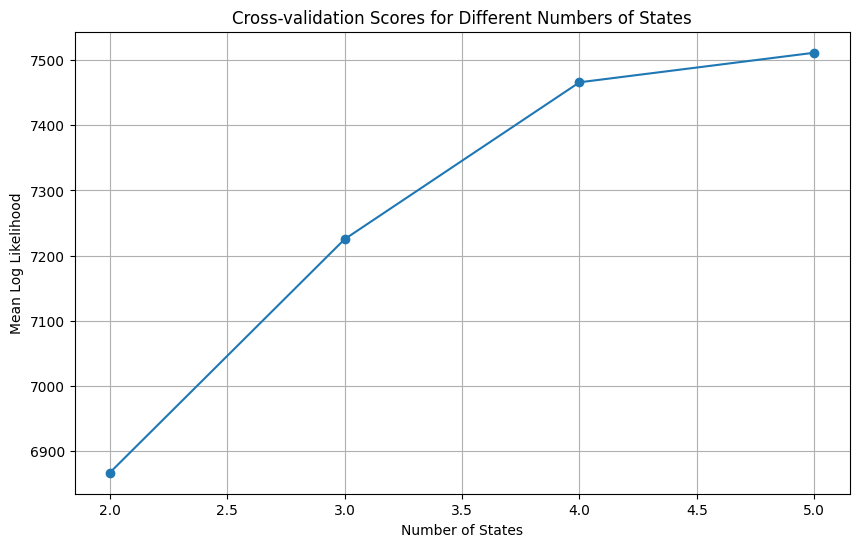

REZUSDT - Optimal states: 5 (CV Score: 7511.41)

Data Split Info:
Training period: 2024-10-03 15:15:00 to 2025-01-01 15:00:00
Testing period: 2025-01-01 15:15:00 to 2025-01-08 11:30:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 37102.42470817071 is not greater than 37102.71651866928. Delta is -0.291810498572886
Model is not converging.  Current: 44443.21202420234 is not greater than 44443.34094848349. Delta is -0.1289242811544682
Model is not converging.  Current: 21052.208745989898 is not greater than 21052.468452571316. Delta is -0.25970658141886815
Model is not converging.  Current: 29601.259448591678 is not greater than 29601.318994698846. Delta is -0.05954610716798925
Model is not converging.  Current: 9733.942039870231 is not greater than 9788.246763005453. Delta is -54.30472313522114
Model is not converging.  Current: 10150.977110071746 is not greater than 10150.987795632618. Delta is -0.010685560871934285
Model is not converging.  Current: 21515.477822305682 is not greater than 21515.494295363504. Delta is -0.016473057821713155
Model is not converging.  Current: 49384.27255020886 is not greater than 49384.28402322849. Delta is -0.011473019629193004


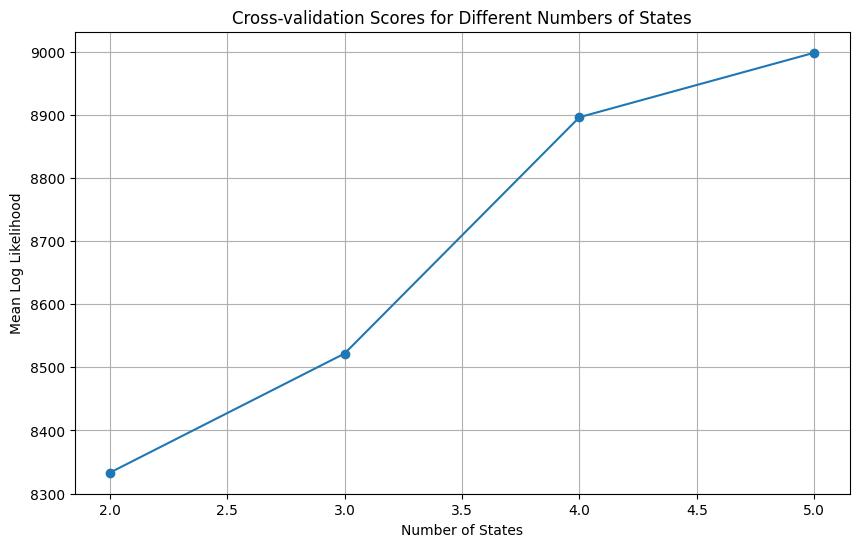

WANUSDT - Optimal states: 5 (CV Score: 8998.41)

Data Split Info:
Training period: 2024-10-03 15:15:00 to 2025-01-01 15:00:00
Testing period: 2025-01-01 15:15:00 to 2025-01-08 11:30:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 10703.622989729662 is not greater than 10703.623643702598. Delta is -0.0006539729365613312
Model is not converging.  Current: 21798.296409003153 is not greater than 21798.396882476325. Delta is -0.1004734731723147
Model is not converging.  Current: 31564.22275998228 is not greater than 31564.6238182296. Delta is -0.40105824732017936
Model is not converging.  Current: 51934.1203890556 is not greater than 51934.2190513103. Delta is -0.09866225469886558
Model is not converging.  Current: 10788.907786458465 is not greater than 10788.912846984682. Delta is -0.005060526216766448
Model is not converging.  Current: 32375.65278690619 is not greater than 32375.704618411437. Delta is -0.051831505246809684
Model is not converging.  Current: 43551.076646575995 is not greater than 43551.09498971687. Delta is -0.018343140873184893


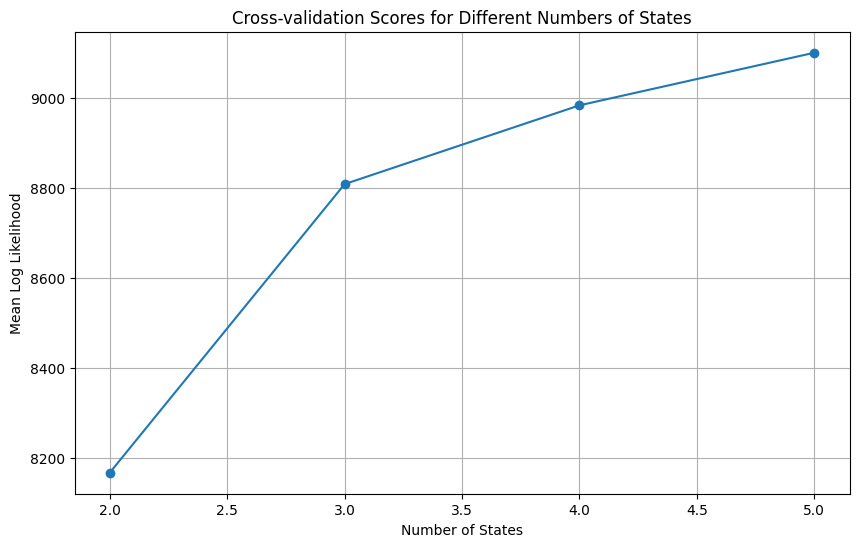

VIBUSDT - Optimal states: 5 (CV Score: 9101.08)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 8935.827735636103 is not greater than 8935.849504855909. Delta is -0.02176921980571933
Model is not converging.  Current: 18787.08970628305 is not greater than 18787.090354911783. Delta is -0.0006486287311417982
Model is not converging.  Current: 19360.279671753888 is not greater than 19360.285817892203. Delta is -0.0061461383156711236


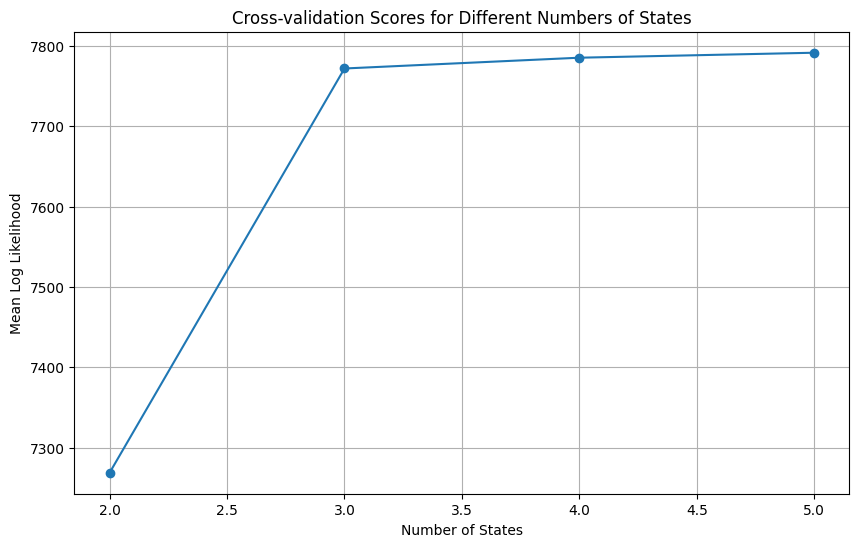

BIFIUSDT - Optimal states: 5 (CV Score: 7791.66)

Data Split Info:
Training period: 2024-10-03 22:00:00 to 2025-01-01 21:45:00
Testing period: 2025-01-01 22:00:00 to 2025-01-08 18:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 19657.168229439674 is not greater than 19658.34421411978. Delta is -1.1759846801069216
Model is not converging.  Current: 25944.67499319742 is not greater than 25945.395928505477. Delta is -0.7209353080579604
Model is not converging.  Current: 9556.468978339984 is not greater than 9556.47433794531. Delta is -0.005359605325793382
Model is not converging.  Current: 35339.197022469525 is not greater than 35339.19731305893. Delta is -0.0002905894070863724
Model is not converging.  Current: 43038.79297242596 is not greater than 43038.93011243737. Delta is -0.13714001140760956
Model is not converging.  Current: 9545.274481916545 is not greater than 9545.299197625849. Delta is -0.024715709303563926
Model is not converging.  Current: 19947.070587450875 is not greater than 19947.24161068939. Delta is -0.1710232385157724


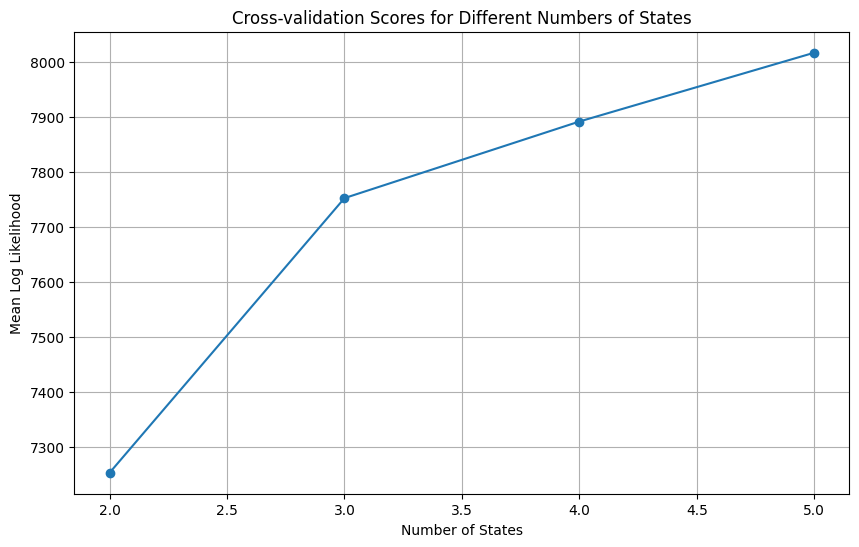

TRUUSDT - Optimal states: 5 (CV Score: 8016.53)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 44216.10376512168 is not greater than 44216.61179714961. Delta is -0.5080320279303123
Model is not converging.  Current: 9431.697731084812 is not greater than 9431.701441368214. Delta is -0.0037102834012330277
Model is not converging.  Current: 46632.94941821631 is not greater than 46632.970219326206. Delta is -0.020801109894819092
Model is not converging.  Current: 9713.816068701899 is not greater than 9714.197901144928. Delta is -0.3818324430285429
Model is not converging.  Current: 29820.607085480427 is not greater than 29820.607215613803. Delta is -0.00013013337593292817
Model is not converging.  Current: 47600.77197980855 is not greater than 47600.77544385416. Delta is -0.003464045606961008
Model is not converging.  Current: 9794.634107411923 is not greater than 9863.821618506125. Delta is -69.18751109420191
Model is not converging.  Current: 48284.38983166797 is not greater than 48284.390822523426. Delta is -0.0009908554566209204


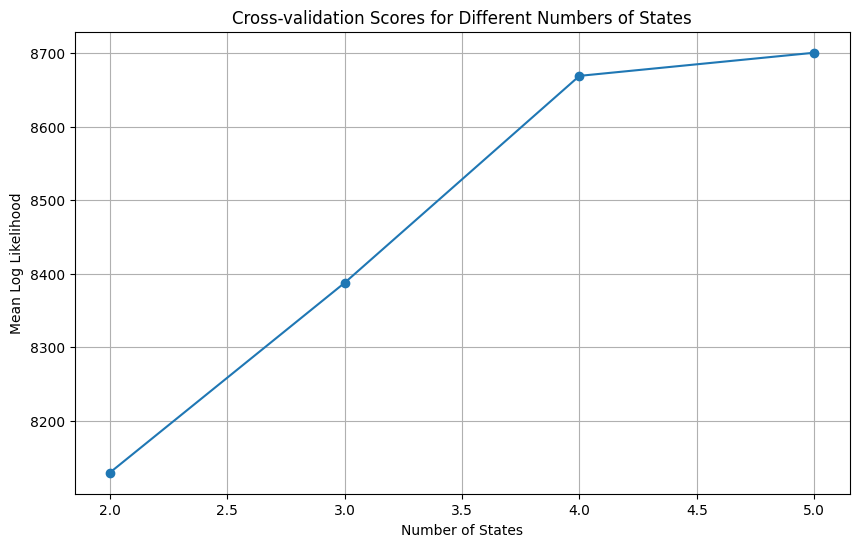

GNSUSDT - Optimal states: 5 (CV Score: 8700.25)

Data Split Info:
Training period: 2024-10-04 00:30:00 to 2025-01-02 00:15:00
Testing period: 2025-01-02 00:30:00 to 2025-01-08 20:45:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 11384.35248916552 is not greater than 11384.430635520128. Delta is -0.07814635460817954
Model is not converging.  Current: 11496.707168594836 is not greater than 11496.72904126339. Delta is -0.02187266855435155
Model is not converging.  Current: 20723.244815708298 is not greater than 20723.83501520717. Delta is -0.5901994988707884
Model is not converging.  Current: 30582.473824868677 is not greater than 30582.605850072618. Delta is -0.1320252039404295
Model is not converging.  Current: 51282.19535455423 is not greater than 51282.73346566804. Delta is -0.5381111138121923
Model is not converging.  Current: 11631.788808032004 is not greater than 11631.790790588302. Delta is -0.001982556297662086
Model is not converging.  Current: 21131.04844082245 is not greater than 21131.05447053477. Delta is -0.006029712320014369
Model is not converging.  Current: 11729.097177697631 is not greater than 11729.105813261458. Delta is -0.00863556382682873
Model is not con

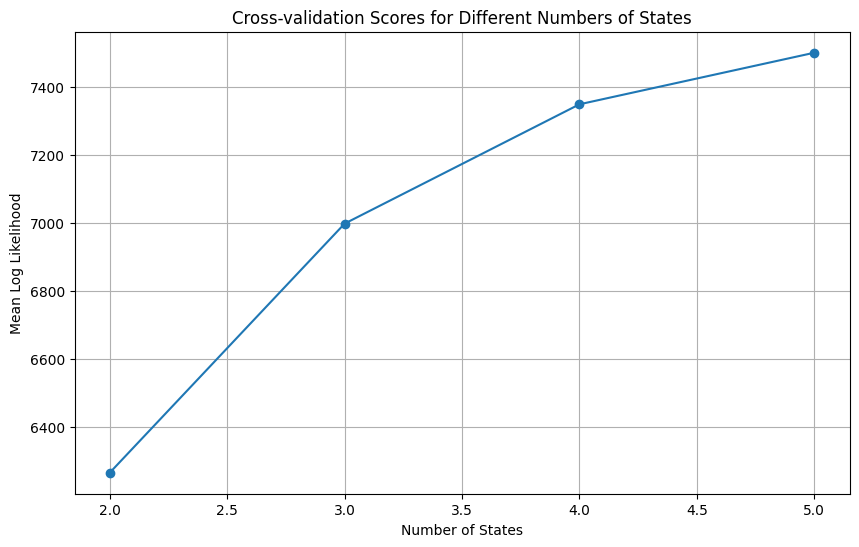

Model is not converging.  Current: 7784.829648418508 is not greater than 7784.849513359408. Delta is -0.019864940899424255


PROMUSDT - Optimal states: 5 (CV Score: 7502.09)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 27970.07690004493 is not greater than 27970.196509572324. Delta is -0.11960952739536879
Model is not converging.  Current: 37643.35014167075 is not greater than 37643.8420931779. Delta is -0.4919515071451315
Model is not converging.  Current: 46475.04523928645 is not greater than 46475.726023601725. Delta is -0.680784315271012
Model is not converging.  Current: 8115.695126124668 is not greater than 8128.740602785533. Delta is -13.04547666086546
Model is not converging.  Current: 28871.458364823484 is not greater than 28871.561150417245. Delta is -0.10278559376092744


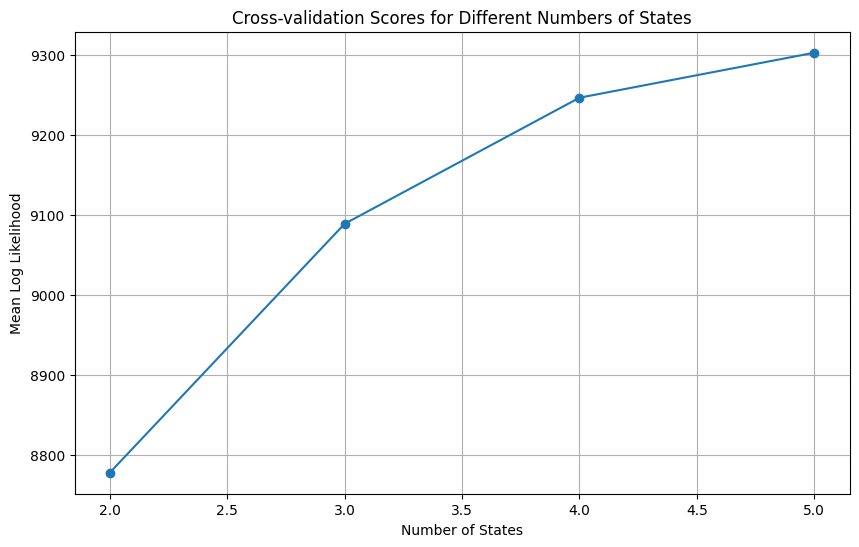

JUVUSDT - Optimal states: 5 (CV Score: 9302.99)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 18588.862608584197 is not greater than 18588.934709206253. Delta is -0.07210062205558643
Model is not converging.  Current: 9594.689857579664 is not greater than 9594.82797630984. Delta is -0.1381187301758473
Model is not converging.  Current: 19432.922484533457 is not greater than 19432.959413307053. Delta is -0.03692877359571867
Model is not converging.  Current: 9725.619888258274 is not greater than 9725.638941509365. Delta is -0.019053251091463608
Model is not converging.  Current: 19629.80866685084 is not greater than 19662.08476644642. Delta is -32.27609959557958
Model is not converging.  Current: 29316.792096548277 is not greater than 29316.954472291167. Delta is -0.1623757428897079
Model is not converging.  Current: 39289.48535161528 is not greater than 39289.501777290854. Delta is -0.01642567557428265
Model is not converging.  Current: 9397.742218254245 is not greater than 9436.587221370388. Delta is -38.845003116142834
Model is not convergin

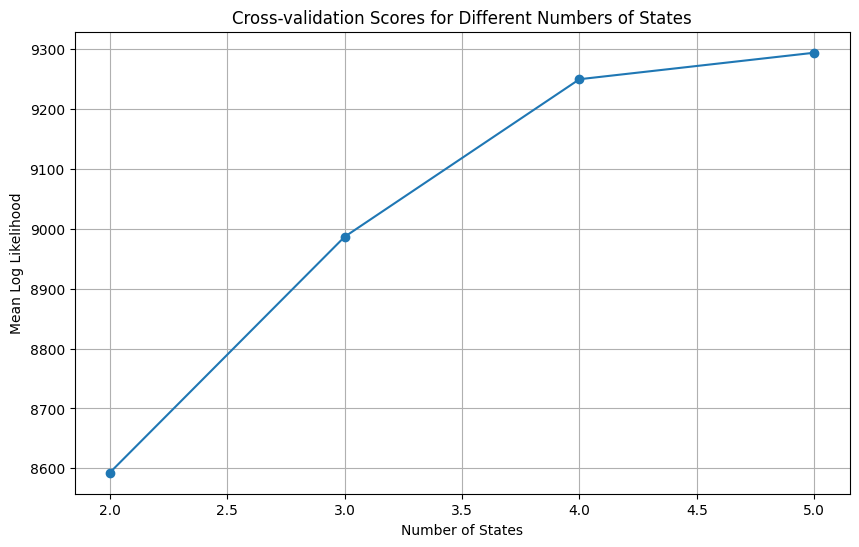

ARDRUSDT - Optimal states: 5 (CV Score: 9294.15)

Data Split Info:
Training period: 2024-10-03 15:15:00 to 2025-01-01 15:00:00
Testing period: 2025-01-01 15:15:00 to 2025-01-08 11:30:00
Training samples: 8640
Testing samples: 658


Model is not converging.  Current: 26371.075643864828 is not greater than 26378.37428464963. Delta is -7.298640784803865
Model is not converging.  Current: 36601.36333170978 is not greater than 36611.03374956256. Delta is -9.670417852779792
Model is not converging.  Current: 44781.818672925416 is not greater than 44790.78127278337. Delta is -8.962599857957684
Model is not converging.  Current: 7698.965893512668 is not greater than 7699.015589944441. Delta is -0.049696431772645155
Model is not converging.  Current: 38727.21236330744 is not greater than 38727.2954479537. Delta is -0.08308464626315981
Model is not converging.  Current: 47739.58346241997 is not greater than 47739.96874835078. Delta is -0.38528593080991413
Model is not converging.  Current: 28728.85754652467 is not greater than 28729.269347341087. Delta is -0.4118008164186904
Model is not converging.  Current: 39615.592492749776 is not greater than 39615.709282025164. Delta is -0.11678927538741846
Model is not converging.  

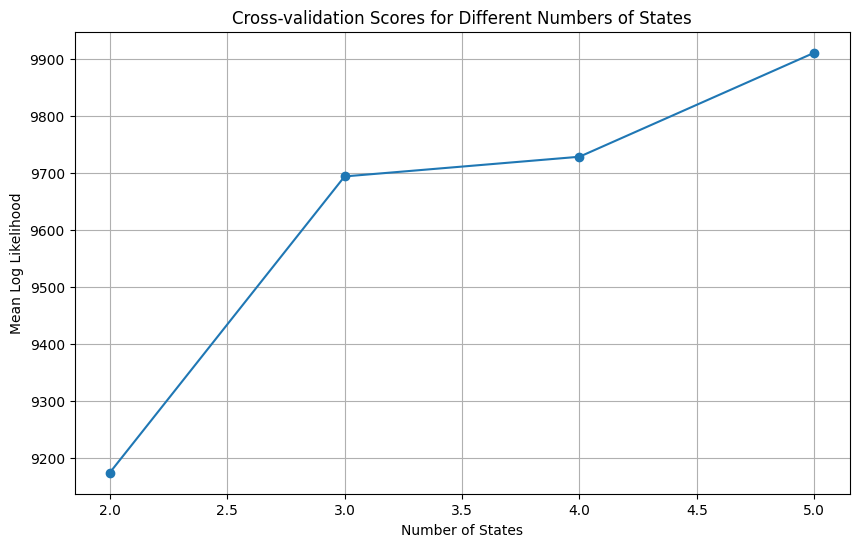

PSGUSDT - Optimal states: 5 (CV Score: 9910.56)

Data Split Info:
Training period: 2024-10-03 15:00:00 to 2025-01-01 14:45:00
Testing period: 2025-01-01 15:00:00 to 2025-01-08 11:15:00
Training samples: 8640
Testing samples: 658


In [45]:
# Process historical data and prepare train-test splits
feature_dfs = {}
optimal_states_by_symbol = {}

# Read all historical CSV files
historical_files = glob.glob("data/historical/historical_*.csv")

for file_path in historical_files:
    try:
        # Extract symbol from filename
        symbol = file_path.split('_')[-1].replace('.csv', '')
        
        # Read historical data
        df = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')
        
        # Get train-test split with features already calculated
        train_features, test_features = engineer.prepare_train_test(df)
        
        # Store the features
        feature_dfs[symbol] = {
            'train': train_features,
            'test': test_features
        }
        
        # Find optimal states using training features
        optimal_states, cv_score = engineer.find_optimal_states(train_features)
        optimal_states_by_symbol[symbol] = {
            'n_states': optimal_states,
            'cv_score': cv_score
        }
        print(f"{symbol} - Optimal states: {optimal_states} (CV Score: {cv_score:.2f})")
            
    except Exception as e:
        print(f"Error processing {symbol}: {str(e)}")
        continue

print(f"\nProcessed features and splits for {len(feature_dfs)} symbols")
print("\nOptimal states summary:")
for symbol, info in optimal_states_by_symbol.items():
    print(f"{symbol}: {info['n_states']} states (CV Score: {info['cv_score']:.2f})")

### correlation heatmap
initially, we will look at the correlation between features for a single symbol.

thoughts on feature selection:
- returns and volatility show no correlation
- volume intensity and returns are weakly correlated
- volume intensity and volatility are weakly correlated
- rsi and returns show relatively moderate correlation
  
it appears that the features set is well balanced and captures the price movement, volatility, volume, and momentum.


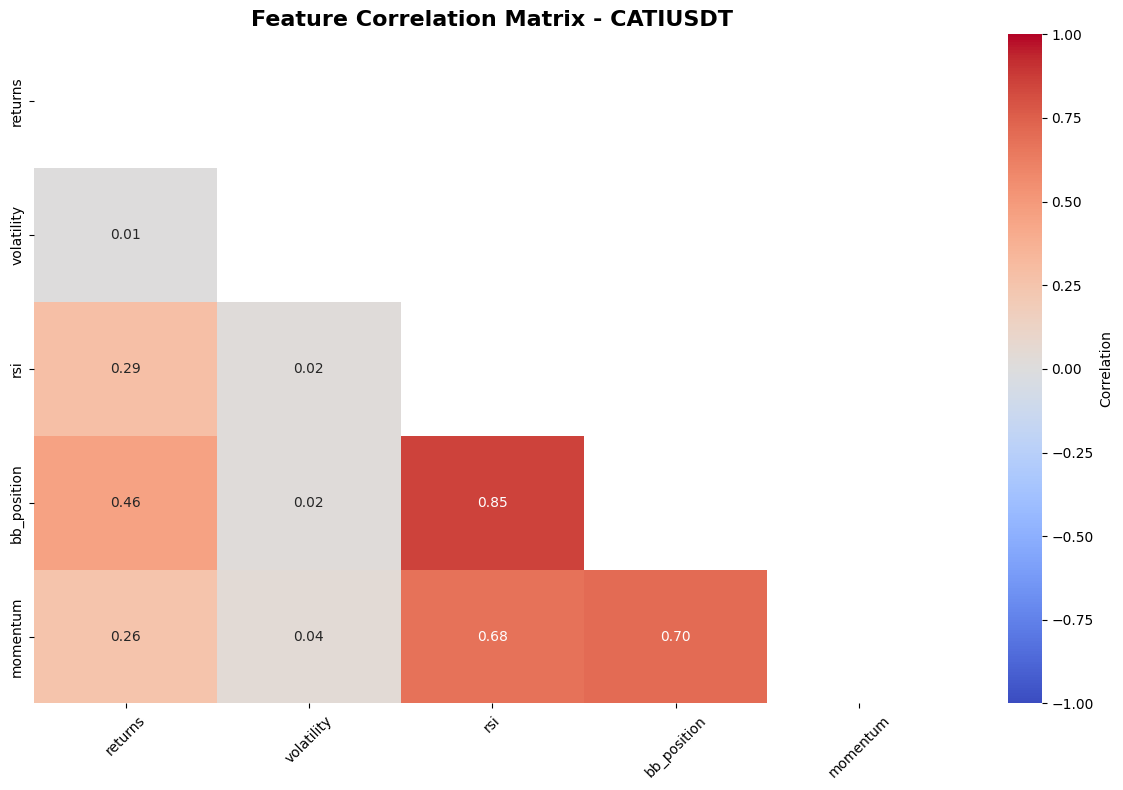

In [20]:
symbol = list(feature_dfs.keys())[0]  # first symbol
features = feature_dfs[symbol]

# correlation Heatmap
plt.figure(figsize=(12, 8))

corr_matrix = features.corr()

# craete heatmap
sns.heatmap(
    corr_matrix,
    annot=True,  # annotate with corr valuse
    fmt=".2f",   # limit to 2 decimal points
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),  # show lower triangle
    cmap="coolwarm",  
    vmin=-1, vmax=1,  # correlation range
    center=0,
    cbar_kws={'label': 'Correlation'}  # add labels to color bar
)

plt.title(f'Feature Correlation Matrix - {symbol}', fontsize=16, weight='bold')
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### feature distributions
thoughts on feature distributions:
- returns are normally distributed
- volatility is skewed to the right
- volume intensity is skewed to the right
- rsi is almost normally distributed. i mean its around 49.5 so that's good not bad


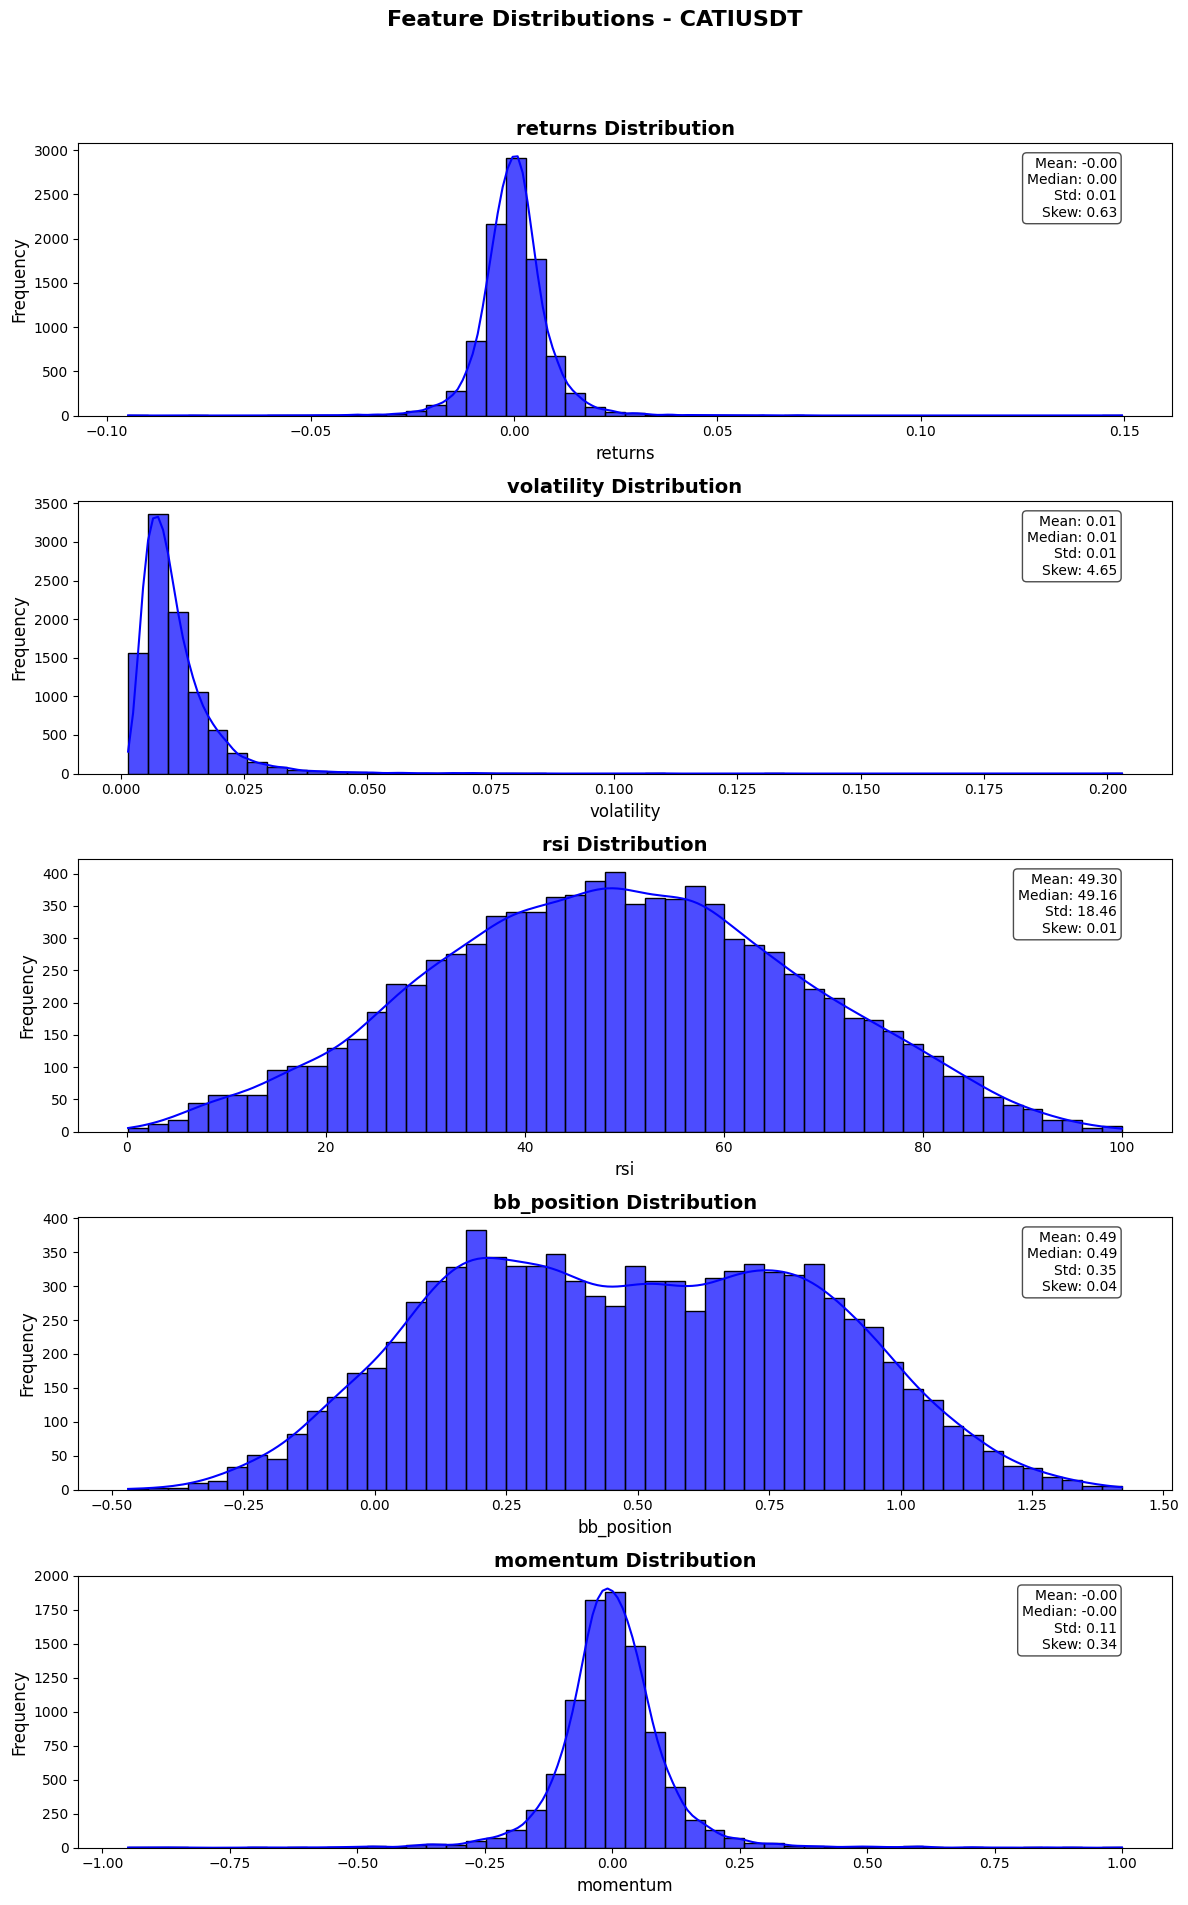

In [21]:
num_features = features.select_dtypes(include=np.number).columns  # select numerical features
features_subset = features[num_features]  # subset of numerical features

fig, axes = plt.subplots(len(features_subset.columns), 1, figsize=(12, len(features_subset.columns) * 4))

for i, feature in enumerate(features_subset.columns):
    ax = axes[i]
    sns.histplot(features_subset[feature], bins=50, kde=True, ax=ax, color='blue', alpha=0.7)
    ax.set_title(f'{feature} Distribution', fontsize=14, weight='bold')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # add a text box with statistics
    mean = features_subset[feature].mean()
    median = features_subset[feature].median()
    std = features_subset[feature].std()
    skew = features_subset[feature].skew()
    ax.text(0.95, 0.95,
            f"Mean: {mean:.2f}\nMedian: {median:.2f}\nStd: {std:.2f}\nSkew: {skew:.2f}",
            transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.suptitle(f'Feature Distributions - {symbol}', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # should be enough space for suptitle
plt.show()

In [22]:
# Show what features we have for one symbol
symbol = list(feature_dfs.keys())[0]
print(f"Example features for {symbol}:")
print("\nFeature DataFrame shape:", feature_dfs[symbol].shape)
print("\nFeature columns:")
print(feature_dfs[symbol].head())

Example features for CATIUSDT:

Feature DataFrame shape: (9298, 5)

Feature columns:
                      returns  volatility        rsi  bb_position  momentum
timestamp                                                                  
2024-10-03 15:00:00 -0.011389    0.020062  43.165364    -0.043460 -0.154457
2024-10-03 15:15:00 -0.008183    0.025218  36.573989    -0.066037 -0.234226
2024-10-03 15:30:00  0.002661    0.017999  41.463314     0.069849 -0.220754
2024-10-03 15:45:00  0.037814    0.041359  51.612799     0.732883 -0.103098
2024-10-03 16:00:00 -0.008137    0.015362  43.495847     0.580108 -0.007870


## TRAINING DATA

In [23]:
# let's set up our training window (last 3 months)
def prepare_training_data(df: pd.DataFrame, training_days: int = 90) -> pd.DataFrame:
    """prepare training data with specified window"""
    end_date = df.index[-1]
    start_date = end_date - timedelta(days=training_days)
    return df[start_date:end_date]

In [24]:
# training data for one symbol
training_data = prepare_training_data(feature_dfs[symbol])
print(f"\ntraining data for {symbol}:")
print("period:", training_data.index[1], "to", training_data.index[-1])
print("observations:", len(training_data))


training data for CATIUSDT:
period: 2024-10-10 11:30:00 to 2025-01-08 11:15:00
observations: 8641


In [25]:
@dataclass
class HMMConfig:
    n_states: int = 3           # no. of hidden states
    n_iter: int = 150           # maximum iterations for training
    tol: float = 1e-5           # convergence tolerance
    random_seed: int = 42 
    init_params: str = "kmeans"

In [26]:
config = HMMConfig()

class HMMMarketCycle:
    """Gaussian Hidden Markov Model (HMM) for market cycle detection."""

    def __init__(self, config: HMMConfig, feature_columns: List[str]):
        self.config = config
        self.feature_columns = feature_columns
        self.model = hmm.GaussianHMM(
            n_components=config.n_states,
            covariance_type="diag",
            n_iter=config.n_iter,
            tol=config.tol,
            random_state=config.random_seed,
            init_params=config.init_params,     # kmeans is a good starting point, update later !!
        )
        self.scaler = StandardScaler()
        self.trained = False
        self.state_labels = []

In [27]:
def _validate_features(self, features: pd.DataFrame) -> None:
    """ensure the required features are present in the DataFrame"""
    missing_features = set(self.feature_columns) - set(features.columns)
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")

def _prepare_features(self, features: pd.DataFrame) -> np.ndarray:
    """validate and scale the feature data"""
    self._validate_features(features)
    X = features[self.feature_columns].values
    return self.scaler.fit_transform(X) if not self.trained else self.scaler.transform(X)

In [28]:
# Add methods to class
HMMMarketCycle._validate_features = _validate_features
HMMMarketCycle._prepare_features = _prepare_features

In [29]:
# note to self: before making predictions, i check if the model is trained. if it's not, raise an error.
# after ensuring the model is ready, i prepare the features and compute the state probabilities using `predict_proba()`.
# then, i predict the most likely state for each data point using `predict()`.
# i want the results to be in a DataFrame for easy access, where each row corresponds to the data points
# and each column holds the probability for a given state (e.g., bull, bear, neutral).
def predict(self, data: pd.DataFrame) -> pd.DataFrame:
    """predict the hidden states for the given data and return a DataFrame with state probabilities."""
    if not self.trained:
        raise RuntimeError("train the model first.")
    X = self._prepare_features(data)
    state_probs = self.model.predict_proba(X)
    states = self.model.predict(X)

    results = pd.DataFrame(state_probs, columns=[f"{label}_prob" for label in self.state_labels], index=data.index)
    results["state"] = [self.state_labels[state] for state in states]
    return results

HMMMarketCycle.predict = predict

In [30]:
# note to self: Here, I’m classifying the states based on their mean values of returns and volatility.
# the idea is to classify states into 'bull', 'bear', or 'neutral' based on these two features.
# i use the "returns" and "volatility" features to make the classification more intuitive:
# - Bull: High returns, low volatility
# - Bear: Low returns, high volatility
# - Neutral: Everything else (default case)
# first, get the predicted states, then compute the mean feature values for each state.
# use the median volatility to separate the bull and bear states from neutral ones.
def _assign_state_labels(self, X: np.ndarray) -> List[str]:
    """Assign labels to states based on their features."""
    states = self.model.predict(X)
    state_means = np.array([X[states == i].mean(axis=0) for i in range(self.config.n_states)])
    
    # Get indices for returns and volatility
    returns_idx = self.feature_columns.index("returns")
    vol_idx = self.feature_columns.index("volatility")
    
    # Calculate median values for classification
    median_returns = np.median(state_means[:, returns_idx])
    median_volatility = np.median(state_means[:, vol_idx])
    
    labels = []
    for i in range(self.config.n_states):
        returns = state_means[i, returns_idx]
        volatility = state_means[i, vol_idx]
        
        # More aggressive classification
        if returns > 0:
            labels.append("bull")
        elif returns < 0:
            labels.append("bear")
        else:
            labels.append("neutral")
    
    print("State Classification:")
    for i, label in enumerate(labels):
        print(f"State {i}: {label} (Returns: {returns:.6f}, Volatility: {volatility:.6f})")
    
    return labels

# Update the method in your model
HMMMarketCycle._assign_state_labels = _assign_state_labels

In [31]:
# note to self: AIC balances model fit and complexity.
# start by calculating the number of parameters (n_params), which depends on the number of states
# and the features involved. then, plug into the formula
# keep in mind, AIC doesn't penalize large datasets as much, so it's good for comparison.
def _calculate_aic(self, X: np.ndarray) -> float:
    """calculate the Akaike Information Criterion (AIC)."""
    n_params = self.config.n_states * (len(self.feature_columns) + self.config.n_states - 1)
    return -2 * self.model.score(X) + 2 * n_params


# useful for avoiding overfitting on large datasets since it penalizes complex models more heavily.
# like before, calculate n_params and substitute into the formula.
def _calculate_bic(self, X: np.ndarray) -> float:
    """calculate the Bayesian Information Criterion (BIC)."""
    n_params = self.config.n_states * (len(self.feature_columns) + self.config.n_states - 1)
    return -2 * self.model.score(X) + n_params * np.log(len(X))

HMMMarketCycle._calculate_aic = _calculate_aic
HMMMarketCycle._calculate_bic = _calculate_bic

In [32]:
def train(self, data: pd.DataFrame) -> Dict[str, Any]:
    """train the HMM using the baum-welch algorithm and return model performance metrics"""
    X = self._prepare_features(data)
    self.model.fit(X)
    self.trained = True
    self.state_labels = self._assign_state_labels(X)

    metrics = {
        "log_likelihood": self.model.score(X),
        "n_iter": self.model.monitor_.iter,
        "converged": self.model.monitor_.converged,
        "aic": self._calculate_aic(X),
        "bic": self._calculate_bic(X),
    }
    return metrics

HMMMarketCycle.train = train

In [33]:

@dataclass
class TradingConfig:
    initial_balance: float = 10000.0
    trading_fee: float = 0.001
    position_size: float = 0.95
    n_iter: int = 150
    stop_loss_pct: float = 0.05  # 5% stop loss
    trailing_stop_pct: float = 0.07  # 7% trailing stop

trading_config = TradingConfig()

In [34]:
from pprint import pprint


pprint(list((i, x) for i, x in enumerate(feature_dfs.keys())))




[(0, 'CATIUSDT'),
 (1, 'FIROUSDT'),
 (2, 'GTCUSDT'),
 (3, 'CITYUSDT'),
 (4, 'BARUSDT'),
 (5, 'ALCXUSDT'),
 (6, 'ACEUSDT'),
 (7, 'PDAUSDT'),
 (8, 'BADGERUSDT'),
 (9, 'MBOXUSDT'),
 (10, 'REZUSDT'),
 (11, 'WANUSDT'),
 (12, 'VIBUSDT'),
 (13, 'BIFIUSDT'),
 (14, 'TRUUSDT'),
 (15, 'GNSUSDT'),
 (16, 'PROMUSDT'),
 (17, 'JUVUSDT'),
 (18, 'ARDRUSDT'),
 (19, 'PSGUSDT'),
 (20, 'LEVERUSDT'),
 (21, 'ASTUSDT'),
 (22, 'LISTAUSDT'),
 (23, 'BETAUSDT'),
 (24, 'DIAUSDT'),
 (25, 'FIOUSDT'),
 (26, 'VICUSDT'),
 (27, 'PHBUSDT'),
 (28, 'DUSKUSDT'),
 (29, 'PERPUSDT'),
 (30, 'ACMUSDT'),
 (31, 'FISUSDT'),
 (32, 'DEGOUSDT'),
 (33, 'CTXCUSDT'),
 (34, 'ERNUSDT'),
 (35, 'HIGHUSDT'),
 (36, 'UFTUSDT'),
 (37, 'PORTOUSDT'),
 (38, 'ATAUSDT'),
 (39, 'CREAMUSDT'),
 (40, 'UTKUSDT'),
 (41, 'AMBUSDT'),
 (42, 'ALICEUSDT'),
 (43, 'MBLUSDT'),
 (44, 'ADXUSDT'),
 (45, 'USDPUSDT'),
 (46, 'DATAUSDT'),
 (47, 'NKNUSDT'),
 (48, 'MAVUSDT'),
 (49, 'NFPUSDT'),
 (50, 'AEURUSDT'),
 (51, 'LINAUSDT'),
 (52, 'REQUSDT'),
 (53, 'GHSTUSDT'),
 (54, 

In [35]:
symbol = list(feature_dfs.keys())[11]
train_data = train_test_splits[symbol]['train']
test_data = train_test_splits[symbol]['test']

# Load price data
price_data = pd.read_csv(f"data/historical/historical_{symbol}.csv", 
                        index_col='timestamp', 
                        parse_dates=True)

print("Symbol:", symbol)
print("Test data shape:", test_data.shape)
print("Price data shape:", price_data.shape)

Symbol: WANUSDT
Test data shape: (658, 5)
Price data shape: (9312, 5)


In [36]:
model_config = HMMConfig()
model = HMMMarketCycle(model_config, ['returns', 'volatility', 'rsi', 'momentum', 'bb_position'])
model.train(train_data)
predictions = model.predict(test_data)

print("Predictions shape:", predictions.shape)
print("\nState distribution:")
print(predictions['state'].value_counts())

State Classification:
State 0: bull (Returns: -0.348343, Volatility: 1.530480)
State 1: bear (Returns: -0.348343, Volatility: 1.530480)
State 2: bear (Returns: -0.348343, Volatility: 1.530480)
Predictions shape: (658, 4)

State distribution:
state
bear    337
bull    321
Name: count, dtype: int64


In [37]:
print("Prediction states distribution:")
print(predictions['state'].value_counts())
print("\nFirst few predictions:")
print(predictions.head())
print("\nFirst few price data points:")
print(price_data.head())
print("\nTime ranges:")
print("Predictions:", predictions.index.min(), "to", predictions.index.max())
print("Price data:", price_data.index.min(), "to", price_data.index.max())

Prediction states distribution:
state
bear    337
bull    321
Name: count, dtype: int64

First few predictions:
                     bull_prob     bear_prob  bear_prob state
timestamp                                                    
2025-01-01 15:15:00   0.000000  0.000000e+00   1.000000  bear
2025-01-01 15:30:00   0.994892  4.923360e-06   0.005103  bull
2025-01-01 15:45:00   0.999990  3.679455e-10   0.000010  bull
2025-01-01 16:00:00   0.999998  7.122568e-08   0.000002  bull
2025-01-01 16:15:00   0.999996  3.178472e-09   0.000004  bull

First few price data points:
                       open    high     low   close   volume
timestamp                                                   
2024-10-03 11:45:00  0.1609  0.1609  0.1605  0.1607  11560.0
2024-10-03 12:00:00  0.1607  0.1607  0.1592  0.1598  18977.0
2024-10-03 12:15:00  0.1598  0.1603  0.1597  0.1601   8161.0
2024-10-03 12:30:00  0.1600  0.1609  0.1599  0.1601  10039.0
2024-10-03 12:45:00  0.1602  0.1607  0.1601  0.1603  10394

In [38]:
test_period_prices = price_data.loc[test_data.index]


portfolio_values = []
trade_history = []
current_balance = trading_config.initial_balance
units = 0
in_position = False
stop_loss_price = 0
trailing_stop_price = 0

for i in range(len(predictions)):
    date = predictions.index[i]
    try:
        price = test_period_prices.loc[date, 'close']
        state = predictions['state'].iloc[i]
        
        # Check stop-loss conditions if in position
        if in_position:
            # Regular stop-loss check
            if price <= stop_loss_price:
                # Sell at stop-loss
                position_value = units * price
                fee = position_value * trading_config.trading_fee
                current_balance += (position_value - fee)
                trade_history.append({
                    'date': date,
                    'action': 'stop_loss',
                    'price': price,
                    'units': units,
                    'fee': fee,
                    'balance': current_balance
                })
                units = 0
                in_position = False
                continue

            # Update trailing stop if price moves higher
            if price > trailing_stop_price / (1 - trading_config.trailing_stop_pct):
                trailing_stop_price = price * (1 - trading_config.trailing_stop_pct)
                stop_loss_price = max(stop_loss_price, trailing_stop_price)

        # Existing trading logic
        if state == 'bull' and not in_position:
            # Buy
            position_size = current_balance * trading_config.position_size
            units = position_size / price
            fee = position_size * trading_config.trading_fee
            current_balance -= (position_size + fee)
            in_position = True
            
            # Set initial stop-loss and trailing stop
            stop_loss_price = price * (1 - trading_config.stop_loss_pct)
            trailing_stop_price = price * (1 - trading_config.trailing_stop_pct)
            
            trade_history.append({
                'date': date,
                'action': 'buy',
                'price': price,
                'units': units,
                'fee': fee,
                'balance': current_balance,
                'stop_loss': stop_loss_price
            })
            
        elif state == 'bear' and in_position:
            # Regular sell signal
            position_value = units * price
            fee = position_value * trading_config.trading_fee
            current_balance += (position_value - fee)
            trade_history.append({
                'date': date,
                'action': 'sell',
                'price': price,
                'units': units,
                'fee': fee,
                'balance': current_balance
            })
            units = 0
            in_position = False
            
        # Calculate portfolio value
        portfolio_value = current_balance + (units * price) if in_position else current_balance
        portfolio_values.append(portfolio_value)
        
    except KeyError as e:
        print(f"Error at date {date}: {e}")
        continue

# Create results dictionary
results = {
    'final_balance': current_balance,
    'portfolio_values': pd.Series(portfolio_values, index=predictions.index),
    'trade_history': pd.DataFrame(trade_history)
}

print("\nTrading Summary:")
print(f"Number of trades: {len(trade_history)}")
print(f"Final balance: ${results['final_balance']:.2f}")

if len(trade_history) > 0:
    trade_df = pd.DataFrame(trade_history)
    print("\nFirst few trades:")
    print(trade_df.head())
    print("\nLast few trades:")
    print(trade_df.tail())


Trading Summary:
Number of trades: 68
Final balance: $9533.39

First few trades:
                 date action   price         units        fee       balance  \
0 2025-01-01 15:30:00    buy  0.2164  43900.184843   9.500000    490.500000   
1 2025-01-02 14:00:00   sell  0.2309  43900.184843  10.136553  10616.916128   
2 2025-01-02 14:30:00    buy  0.2318  43511.951342  10.086070    520.759736   
3 2025-01-02 15:15:00   sell  0.2307  43511.951342  10.038207  10548.928704   
4 2025-01-02 16:15:00    buy  0.2323  43140.259442  10.021482    517.424953   

   stop_loss  
0   0.205580  
1        NaN  
2   0.220210  
3        NaN  
4   0.220685  

Last few trades:
                  date action   price         units       fee      balance  \
63 2025-01-07 09:30:00   sell  0.2423  37849.727480  9.170989  9634.158076   
64 2025-01-08 08:30:00    buy  0.2132  42928.940769  9.152450   472.555454   
65 2025-01-08 09:30:00   sell  0.2119  42928.940769  9.096643  9560.101360   
66 2025-01-08 10:30:00 

In [39]:
# Calculate buy & hold performance
buy_hold_values = price_data.loc[test_data.index, 'close'] * (trading_config.initial_balance / price_data.loc[test_data.index[0], 'close'])

# Calculate returns and metrics
portfolio_returns = results['portfolio_values'].pct_change().dropna()
benchmark_returns = buy_hold_values.pct_change().dropna()

# Calculate cumulative returns
portfolio_cum_returns = (1 + portfolio_returns).cumprod()
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Calculate drawdowns
portfolio_drawdown = (portfolio_cum_returns - portfolio_cum_returns.cummax()) / portfolio_cum_returns.cummax()
benchmark_drawdown = (benchmark_cum_returns - benchmark_cum_returns.cummax()) / benchmark_cum_returns.cummax()

# Calculate Sharpe ratios (assuming 2% risk-free rate)
risk_free_rate = 0.02
portfolio_sharpe = np.sqrt(252) * (portfolio_returns.mean() - risk_free_rate/252) / portfolio_returns.std()
benchmark_sharpe = np.sqrt(252) * (benchmark_returns.mean() - risk_free_rate/252) / benchmark_returns.std()

metrics = {
    'Portfolio': {
        'Total Return': (results['portfolio_values'].iloc[-1] / results['portfolio_values'].iloc[0] - 1) * 100,
        'Sharpe Ratio': portfolio_sharpe,
        'Max Drawdown': portfolio_drawdown.min() * 100,
        'Daily Volatility': portfolio_returns.std() * 100
    },
    'Benchmark': {
        'Total Return': (buy_hold_values.iloc[-1] / buy_hold_values.iloc[0] - 1) * 100,
        'Sharpe Ratio': benchmark_sharpe,
        'Max Drawdown': benchmark_drawdown.min() * 100,
        'Daily Volatility': benchmark_returns.std() * 100
    }
}

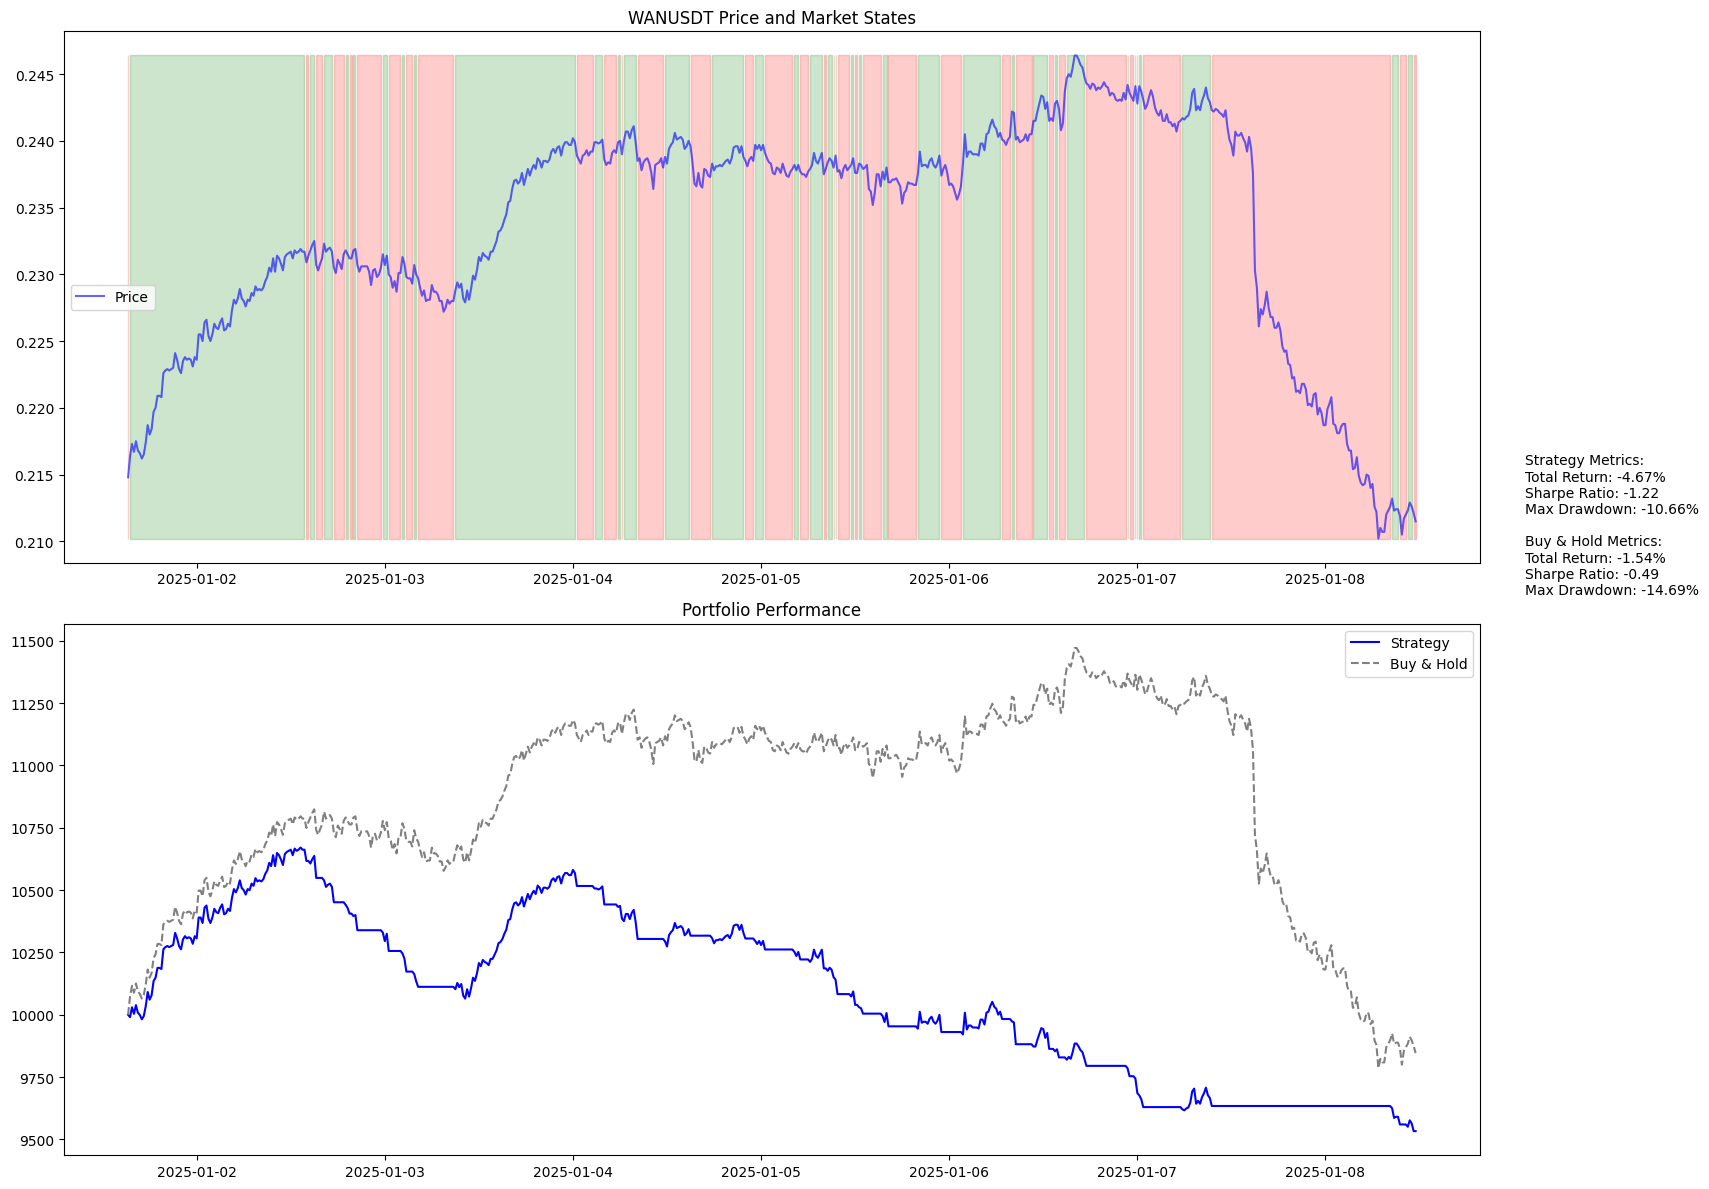


Detailed Performance Metrics:

Portfolio Metrics:
Total Return: -4.67
Sharpe Ratio: -1.22
Max Drawdown: -10.66
Daily Volatility: 0.20

Benchmark Metrics:
Total Return: -1.54
Sharpe Ratio: -0.49
Max Drawdown: -14.69
Daily Volatility: 0.32


In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Price and States
ax1.plot(price_data.loc[test_data.index, 'close'], label='Price', color='blue', alpha=0.6)

# Color states
for state in ['bull', 'bear', 'neutral']:
    mask = predictions['state'] == state
    color = {'bull': 'green', 'bear': 'red', 'neutral': 'gray'}[state]
    ax1.fill_between(test_data.index, 
                     price_data.loc[test_data.index, 'close'].min(), 
                     price_data.loc[test_data.index, 'close'].max(),
                     where=mask, color=color, alpha=0.2)

ax1.set_title(f'{symbol} Price and Market States')
ax1.legend()

# Plot 2: Portfolio Performance
ax2.plot(results['portfolio_values'].index, results['portfolio_values'], 
         label='Strategy', color='blue')
ax2.plot(buy_hold_values.index, buy_hold_values, 
         label='Buy & Hold', color='gray', linestyle='--')
ax2.set_title('Portfolio Performance')
ax2.legend()

# Add metrics as text
metrics_text = (
    f"Strategy Metrics:\n"
    f"Total Return: {metrics['Portfolio']['Total Return']:.2f}%\n"
    f"Sharpe Ratio: {metrics['Portfolio']['Sharpe Ratio']:.2f}\n"
    f"Max Drawdown: {metrics['Portfolio']['Max Drawdown']:.2f}%\n\n"
    f"Buy & Hold Metrics:\n"
    f"Total Return: {metrics['Benchmark']['Total Return']:.2f}%\n"
    f"Sharpe Ratio: {metrics['Benchmark']['Sharpe Ratio']:.2f}\n"
    f"Max Drawdown: {metrics['Benchmark']['Max Drawdown']:.2f}%"
)

plt.figtext(1.02, 0.5, metrics_text, fontsize=10, ha='left')
plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Performance Metrics:")
print("\nPortfolio Metrics:")
for metric, value in metrics['Portfolio'].items():
    print(f"{metric}: {value:.2f}")

print("\nBenchmark Metrics:")
for metric, value in metrics['Benchmark'].items():
    print(f"{metric}: {value:.2f}")